<a href="https://colab.research.google.com/github/Joeri38/inverse-design/blob/master/Bragg_reflector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Intro


We perform inverse design on the Bragg reflector, an optical system with 4 parameters to optimize.


In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" #to plot all variables in a cell

from google.colab import drive

drive.mount('/content/drive')
path = "/content/drive/My Drive/Fulcon 1/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/3wHPlRMB_7lzriw58oHCsae0HZUhlPKYVKxMi4Ayvm4636MbksXKcNc
Mounted at /content/drive


We tested the inverse design on 20 reflection spectra of the Bragg reflector. 


Test transmission | Succes | Test transmission | Succes
--- | --- | --- | ---
1 | 👍 | 3264 | ❌
537 | 👍 | 3468 | 👍
1293 | 👍 | 4859 | 👍
2599 | 👍 | 5874 | 👍
2897 | 👍 | 10799 | 👍

--

Test transmission | Succes | Test transmission | Succes
--- | --- | --- | ---
714 | 👍 | 6744 | ❌
1871 | 👍 | 6921 | 👍
4353 | 👍 | 7456 | ❌
4735 | 👍 | 8291 | 👍
6036 | ❌ | 8615 | 👍

# Step 1: Training the neural network

## Setting up data

In [3]:
import numpy as np

#Create reflector parameters

n_av = np.linspace(1.10, 3.5, 25)
dn = np.linspace(0.1, 2.5, 25)
big_lamb = np.linspace(50, 400, 25)
p = [3, 4, 5, 6, 7, 8, 9]

lamb = np.arange(400, 800, 2)

vector_4 = np.array([(i,j,k,l) for i in n_av for j in dn for k in big_lamb for l in p])

print("We have {} data samples".format(len(vector_4)))

We have 109375 data samples


The reflectivity is given by

$$ r(\lambda) = \frac{-\kappa \sinh (\Gamma l)}{\Gamma \cosh (\Gamma l)-i \delta \sinh (\Gamma l)}. $$

Squaring gives 

$$ R(\lambda) = \frac{\kappa^2 \sinh^2 (\Gamma l)}{\Gamma^2 \cosh^2 (\Gamma l) +  \delta^2 \sinh^2 (\Gamma l)}, $$

or in full

$$ R(\lambda, \Delta n, \bar{n}, \Lambda, p) = \frac{\frac{4 \Delta n^2}{\lambda^2} \sinh^2 \big[p \Lambda \sqrt{\frac{4 \Delta n^2}{\lambda^2} - (\frac{2 \pi \bar{n}}{\lambda} - \frac{\pi}{\Lambda})^2}\big]} 
{\big[\frac{4 \Delta n^2}{\lambda^2} - (\frac{2 \pi \bar{n}}{\lambda} - \frac{\pi}{\Lambda})^2 \big] 
\cosh^2 \big[p \Lambda \sqrt{\frac{4 \Delta n^2}{\lambda^2} - (\frac{2 \pi \bar{n}}{\lambda} - \frac{\pi}{\Lambda})^2}\big] +
(\frac{2 \pi \bar{n}}{\lambda} - \frac{\pi}{\Lambda})^2 
\sinh^2 \big[p \Lambda \sqrt{\frac{4 \Delta n^2}{\lambda^2} - (\frac{2 \pi \bar{n}}{\lambda} - \frac{\pi}{\Lambda})^2}\big]} $$

We have four parameters:

*   $ \Delta n $ is the difference between the indices of refraction of the two materials
*   $ \bar{n} $ is the mean index of refraction of the medium
*   $ \Lambda $ is the total length of a unit cell
*   $ p $ is the number of pairs. We can compute the length $ l = p \Lambda $. Note that $ p $ is a discrete variable. 



In [4]:
# Calculate transmission spectra of the resonator parameters
import matplotlib.pyplot as plt

def trans(n_av, dn, big_lamb, p, lamb): 
  l = p*big_lamb
  kappa = (2*dn)/lamb
  delta = (2*np.pi*n_av/lamb) - (np.pi/big_lamb)
  gamma = np.sqrt(kappa**2 - delta**2 + 0j)

  numerator = (kappa**2) * np.sinh(gamma*l)**2
  denominator = (gamma**2) * np.cosh(gamma*l)**2 + (delta**2) * np.sinh(gamma*l)**2
  T = numerator/denominator
  return T

def make_spect(vector):
  spect = []
  counter = 0
  for param in vector:
    if counter % 10000 == 0:
      print("Computing training sample {} of {}".format(counter, len(vector)))
    counter += 1

    row_spect = trans(param[0], param[1], param[2], param[3], lamb) 
    spect.append(row_spect)
  spect = np.real(np.array(spect))
  print("Shape of spect is {}".format(spect.shape))
  return spect

make_data = False
savename = path + "bragg_spectra_full.npy" 

if make_data:
  spect = make_spect(vector_4)
  np.save(savename, spect)
else:
  spect = np.load(savename)

In [5]:
# Normalize the frequencies to improve the training of the network

def normalize(quartet):
  mean = np.array([2.3, 1.25, 225, 6])
  half_range = np.array([1.2, 1.25, 175, 4])
  norm = np.divide((quartet - mean), half_range)
  return norm

def unnormalize(norm):
  mean = np.array([2.3, 1.25, 225, 6])
  half_range = np.array([1.2, 1.25, 175, 4])
  quartet = norm*half_range + mean
  return quartet

vector_4_norm = np.array([normalize(quartet) for quartet in vector_4])
print(f"Shape vector_4_norm: {vector_4_norm.shape}")
print(f"min-max: {min(vector_4_norm[:, 0]), max(vector_4_norm[:, 0])}")
print(f"min-max: {min(vector_4_norm[:, 1]), max(vector_4_norm[:, 1])}")
print(f"min-max: {min(vector_4_norm[:, 2]), max(vector_4_norm[:, 2])}")
print(f"min-max: {min(vector_4_norm[:, 3]), max(vector_4_norm[:, 3])}")

Shape vector_4_norm: (109375, 4)
min-max: (-0.9999999999999998, 1.0000000000000002)
min-max: (-0.9199999999999999, 1.0)
min-max: (-1.0, 1.0)
min-max: (-0.75, 0.75)


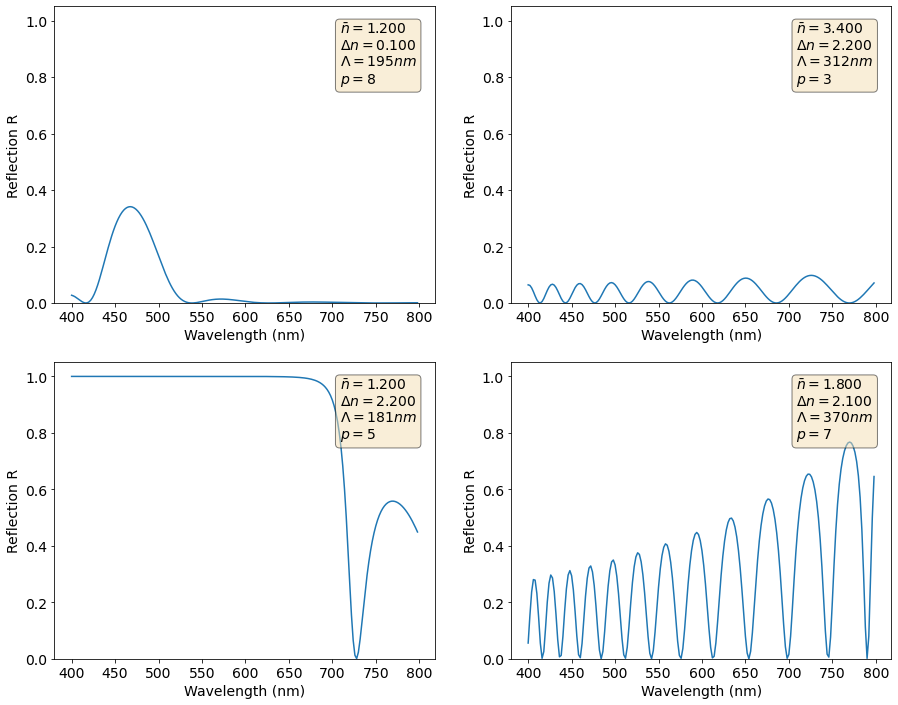

In [6]:
# Plot transmission spectra of Fabry-Pérot resonator

import matplotlib.pyplot as plt

def plot_spects(vects, spects):
  plt.figure(figsize = (15, 6*np.ceil(len(spects)/2)))

  for i, spect in enumerate(spects):
    ax = plt.subplot(np.ceil(len(spects)/2), 2, i + 1)
    param = vects[i]

    plt.plot(lamb, spect)
    plt.xlabel("Wavelength (nm)", fontsize=14)
    plt.ylabel("Reflection R", fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.ylim(0, 1.05)
  
    textstr = '\n'.join((
      r'$\bar{n}=%.3f$' % (param[0]),
      r'$\Delta n=%.3f$' % (param[1]),
      r'$\Lambda=%.i nm$' % (param[2]),
      r'$p=%.i$' % (param[3]),
    ))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.75, 0.95, textstr, transform=ax.transAxes, fontsize=14,
           verticalalignment='top', bbox = props)

#np.random.seed(0) 
idx = np.random.choice(range(len(spect)), 4)
plot_spects(vector_4[idx], spect[idx])

Illustration of the non-uniqueness problem. Different resonator parameters can lead to the same transmission. 

Computing training sample 0 of 4
Shape of spect is (4, 200)


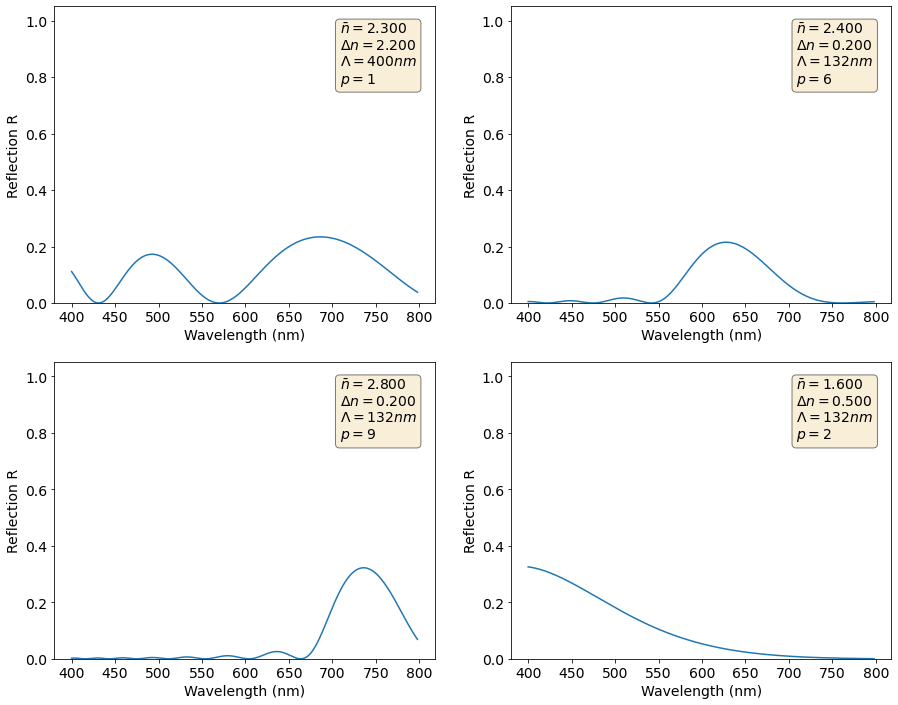

In [7]:
# Compute transmission for some chosen resonator parameters
vects = np.array([[2.3, 2.2, 400, 1], [2.4, 0.2, 132, 6], [2.8, 0.2, 132, 9], [1.6, 0.5, 132, 2]])
spects = make_spect(vects)

# Plot these transmissions
plot_spects(vects, spects) 

## Training 


### Test and training split


We split into a training set and a test set. The training set will be split up later in training and validation set when the network is training. 

In [8]:
import numpy as np

# Pick out test and training data
n_tot = len(vector_4)
n = int(0.9 * n_tot)
n_test = n_tot - n

print(f"We have {n_tot} samples")
print(f"First vector is {vector_4[0]} and last vector is {vector_4[-1]} \n")

index = np.arange(len(spect))
np.random.seed(0)
index = np.random.choice(index, n + n_test, replace = False)

vector_4_train = vector_4_norm[index[:n]]
vector_4_test = vector_4_norm[index[n:]]
print("We have {} training samples and {} test samples".format(len(vector_4_train), len(vector_4_test)))

y_train = spect[index[:n]]
y_test = spect[index[n:]]

We have 109375 samples
First vector is [ 1.1  0.1 50.   3. ] and last vector is [  3.5   2.5 400.    9. ] 

We have 98437 training samples and 10938 test samples


### Training network

Putting training to True will train the neural network. We have done experiments with 4 to 6 hidden layers with either 100 or 200 nodes in each hidden layer. We also compared the Swish and ReLu activation functions. The results are shown in this notebook in the "experiments" section. 

This neural network will be trained to map $ \bar{n}, \Delta n, \Lambda $ and $ p $ to the transmissions. 

In [11]:
%tensorflow_version 2.x
import tensorflow as tf
import pandas as pd
import time
import os.path

# create swish activation function
def swish(x):
    return x*tf.keras.activations.sigmoid(x)
tf.keras.utils.get_custom_objects()['swish'] = tf.keras.layers.Activation(swish)

# Gives (4,2) array, first element is name (eg "loss"), second element is the list
def save_history(history, savename):
    array = np.array(list(history.history.items()))
    np.save(savename, array)

def init_csv(path_exp):
  df = pd.DataFrame(columns=["Run", "Set-up", "Activation", "Train MAE", "Val MAE",
                             "Training time", "Epochs", "Saved as"])
  df.to_csv(path + path_exp + "Training results.csv")

def add_row_to_csv(row, path_exp):
  df = pd.read_csv(path + path_exp + "Training results.csv", index_col=0)
  df = df.append(row, ignore_index=True)
  df.to_csv(path + path_exp + "Training results.csv")

def create_network(layers, nodes, activation):
  #kernel_initializer='glorot_uniform', other options: he_uniform of he_normal

  input_layer = [tf.keras.layers.Flatten(input_shape=(4,))]
  hidden_layers = [tf.keras.layers.Dense(nodes, activation=activation) for i in range(layers)]
  output_layer = [tf.keras.layers.Dense(200)]

  layers = input_layer + hidden_layers + output_layer

  model = tf.keras.models.Sequential(layers)

  model.compile(optimizer="adam",
                   loss='mse',
                   metrics = ['mae'])
  return model

def train_network(model, setup, run, savename, historyname, log_dir, path_exp, activation):
  start = time.time()

  # Callbacks
  %reload_ext tensorboard
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
  es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", verbose=0, patience = 30) 
  checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = savename, monitor='val_mae', 
                                                  verbose=0, save_best_only=True, mode='min')

  # Actual training
  history = model.fit(vector_4_train, y_train, batch_size=200, epochs=1000, validation_split=0.15,
                      callbacks = [tensorboard_callback, checkpoint], verbose=1)
  save_history(history, historyname)

  # Saving info in csv file
  n_epochs = len(history.history['mae'])
  best_index = np.argmin(history.history['val_mae'])
  train_mae = history.history['mae'][best_index]
  val_mae = history.history['val_mae'][best_index]
  # We can't compute the test mae here because this is the last model, not the best one
  diff = time.time() - start
  print(f"Training took {int(np.floor(diff / 60))} mins {int(diff % 60)} seconds")
  train_time = f"{int(np.floor(diff / 60))} mins {int(diff % 60)}s"
  
  row = pd.Series(index=["Run", "Set-up", "Activation", "Train MAE", "Val MAE", 
                         "Training time", "Epochs", "Saved as"],
                  data=[run, setup, activation, train_mae, val_mae, 
                        train_time, n_epochs, savename.replace(path, '')])
  add_row_to_csv(row, path_exp)
  return model

def train_run(number_runs=0):
  path_exp = "Bragg reflector/"
  
  savename = path + path_exp + f"6layers200nodes_run{number_runs}_swish.hdf5"
  historyname = path + path_exp + f"history_6layers200nodes_run{number_runs}_swish.npy"
  logname = path + path_exp + f"logs/fit/6layers200nodes_run{number_runs}_swish"
  activation = 'swish'

  Fulcon = create_network(layers=6, nodes=200, activation=activation)
  Fulcon = train_network(Fulcon, setup=f"6 layers, 200 nodes", 
                         run=number_runs, 
                         savename=savename, 
                         historyname=historyname,
                         log_dir=logname,
                         path_exp=path_exp, 
                         activation=activation)
  
if not os.path.isfile(path + "Bragg reflector/Training results.csv"):
  init_csv(path_exp="Bragg reflector/")
  
training = False

for i in range(1, 2):
  print(f"Busy on run {i}...")
  if training:
    train_run(i)

Busy on run 1...


## Analysis

### Random evaluation

In [22]:
path_exp = "Bragg reflector/"
df = pd.read_csv(path + path_exp + "Training results.csv", index_col=0)
df

,Run,Set-up,Activation,Train MAE,Val MAE,Training time,Epochs,Saved as
0,1,"6 layers, 200 nodes",swish,0.011488,0.010114,38 mins 5s,1000,Bragg reflector/6layers200nodes_run1_swish.hdf5


In [23]:
best_res = df.loc[[df['Val MAE'].idxmin()]]
best_res

,Run,Set-up,Activation,Train MAE,Val MAE,Training time,Epochs,Saved as
0,1,"6 layers, 200 nodes",swish,0.011488,0.010114,38 mins 5s,1000,Bragg reflector/6layers200nodes_run1_swish.hdf5


[ 4299 10076  2562  2574]


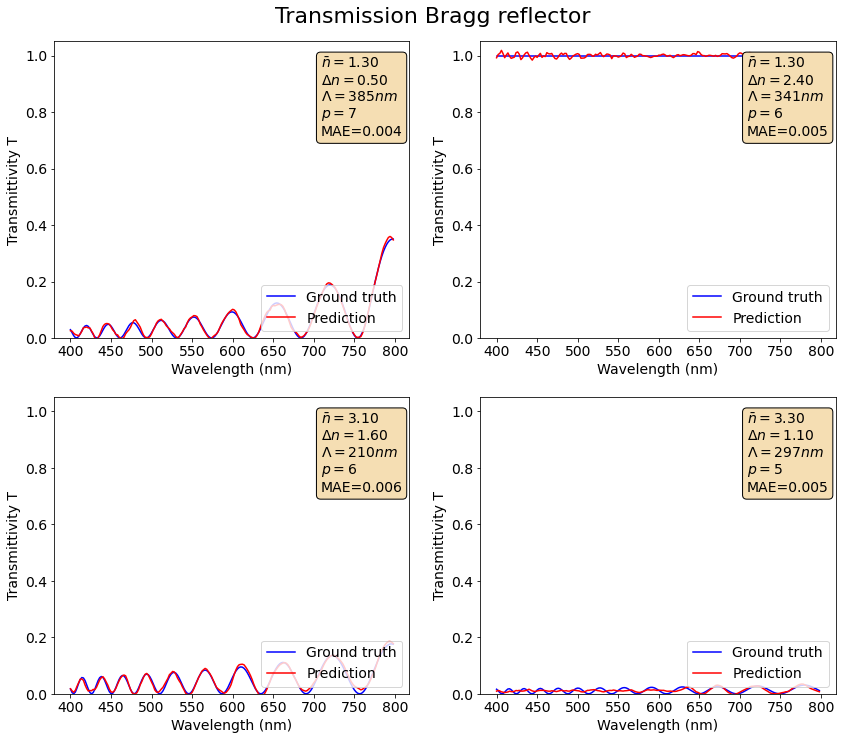

In [24]:
# Sample in this function is normalized
def predict(vector_eval, y_eval, loadname, string="Predictions", swish_bool=False):
  if swish_bool:
    Fulcon = tf.keras.models.load_model(path + loadname,
                                          custom_objects={'Activation' : tf.keras.layers.Activation(swish)})
  else:
    Fulcon = tf.keras.models.load_model(path + loadname)
  pred = Fulcon.predict(vector_eval)
  unnorm = np.array([unnormalize(quartet) for quartet in vector_eval])

  plt.figure("Predictions", figsize = (14,12))
  plt.suptitle(string, fontsize = 22, y=0.92)
  for i in range(len(y_eval)):
    ax = plt.subplot(np.ceil(len(y_eval)/2),2,i+1)

    plt.plot(lamb, y_eval[i], 'b', label="Ground truth")
    plt.plot(lamb, pred[i], 'r', label="Prediction")
    plt.legend(loc = "lower right", fontsize=14)
    plt.xlabel("Wavelength (nm)", fontsize=14)
    plt.ylabel("Transmittivity T", fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.ylim(0, 1.05)

    err = tf.keras.losses.mean_absolute_error(y_eval[i], pred[i])
    textstr = '\n'.join((
      r'$\bar{n}=%.2f$' % (unnorm[i][0]),
      r'$\Delta n=%.2f$' % (unnorm[i][1]),
      r'$\Lambda=%.i nm$' % (unnorm[i][2]),
      r'$p=%.i$' % (unnorm[i][3]),
      r'MAE=%.3f' % (err)))
    props = dict(boxstyle='round', facecolor='wheat', alpha=1)
    ax.text(0.75, 0.95, textstr, transform=ax.transAxes, fontsize=14,
          verticalalignment='top', bbox = props)
   
#np.random.seed(1)
eval_idx = np.random.choice(len(y_test), 4)
print(eval_idx)
vector_4_eval = vector_4_test[eval_idx]
y_eval = y_test[eval_idx]

predict(vector_4_eval, y_eval, 
        loadname = "Bragg reflector/6layers200nodes_run1_swish.hdf5", 
        string="Transmission Bragg reflector", 
        swish_bool=True)

### Training history

The loss at the last epoch: 0.0005
The val_loss at the last epoch: 0.0005
The mae at the last epoch: 0.0104
The val_mae at the last epoch: 0.0101


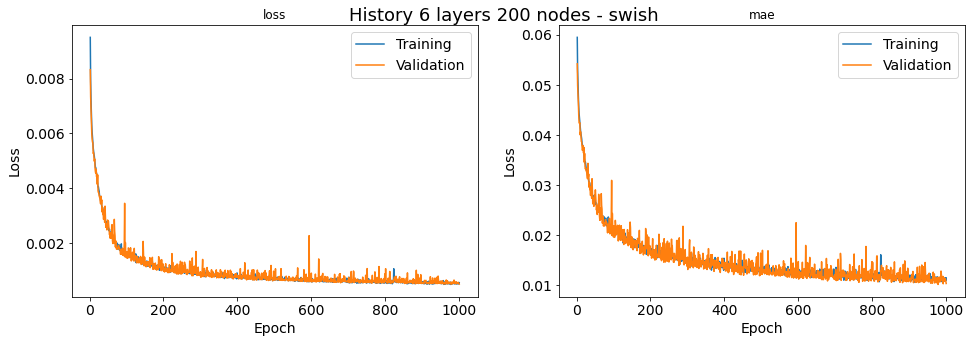

In [25]:
def plot_history(history, string="Training history"):
  plt.figure("Training history", figsize = (16, 5))
  plt.suptitle(string, fontsize=18, y=0.93)

  for i in [0,1]:
      metric1 = history[i,0]
      metric2 = history[i+2,0]

      n_epochs = len(history[i,1])
      plt.subplot(1,2, i+1)
      plt.plot(range(2, n_epochs + 1), history[i,1][1:], label = "Training") 
      plt.plot(range(2, n_epochs + 1), history[i+2,1][1:], label = "Validation") 
      plt.legend(fontsize=14)
      plt.xlabel("Epoch", fontsize=14)
      plt.ylabel("Loss", fontsize=14)
      plt.xticks(fontsize=14)
      plt.yticks(fontsize=14)
      plt.title(metric1)

      print("The " + metric1 + f" at the last epoch: {min(history[i,1][1:]):.4f}")
      print("The " + metric2 + f" at the last epoch: {min(history[i + 2,1][1:]):.4f}")

  plt.show()

def history_merge(history_list):
  for i, line in enumerate(history_list[0]):
    row = []
    for history in history_list:
      row.extend(history[i, 1])
    history_list[0][i, 1] = row
  return history_list[0]

path_exp = "Bragg reflector/"
history = np.load(path + path_exp + f"history_6layers200nodes_run1_swish.npy", allow_pickle = True)
plot_history(history, string="History 6 layers 200 nodes - swish")

### Evaluate model

In [26]:
path_exp = "Bragg reflector/"
Fulcon = tf.keras.models.load_model(path + best_res['Saved as'].values[0],
                                    custom_objects={'Activation' : tf.keras.layers.Activation(swish)})
loss_train, mae_train = Fulcon.evaluate(vector_4_train, y_train, verbose=False)
loss_test, mae_test = Fulcon.evaluate(vector_4_test, y_test, verbose=False)

print(f"Final training loss is {loss_train:.05f}")
print(f"Final training mae is {mae_train:.05f}")
print(f"Final test loss is {loss_test:.05f}")
print(f"Final test mae is {mae_test:.05f}")

Final training loss is 0.00048
Final training mae is 0.01002
Final test loss is 0.00050
Final test mae is 0.01018


# Step 2: Inverse design on $ \bar{n}, \Delta n, \Lambda $ and $ p $

## Best model

In [29]:
# First, we pick out the best neural network that we trained in step 1

import pandas as pd

def file_to_testmae(savename):
  if 'swish' in savename:
    model = tf.keras.models.load_model(path + savename,
                                       custom_objects={'Activation' : tf.keras.layers.Activation(swish)})
  else:
    model = tf.keras.models.load_model(path + savename)
  loss_test, mae_test = model.evaluate(Fd_test, y_test, verbose=False)
  return mae_test

def add_testmae():  
  total_res = train_res
  total_res['Test MAE'] = total_res['Saved as']
  total_res = total_res.reindex(columns=["Run", "Set-up", "Activation", "Train MAE", "Val MAE", "Test MAE", 
                                         "Training time", "Epochs", "Saved as"])
  total_res['Test MAE'] = total_res['Test MAE'].apply(file_to_testmae)
  total_res.to_csv(path + path_exp + "Total results.csv")

path_exp = "Bragg reflector/"
res = pd.read_csv(path + path_exp + "Training results.csv", index_col=0)

In [30]:
best_res = res.loc[[res['Val MAE'].idxmin()]]
best_model = best_res['Saved as'].values[0]
Fulcon = tf.keras.models.load_model(path + best_model,
                                      custom_objects={'Activation' : tf.keras.layers.Activation(swish)})
best_res

,Run,Set-up,Activation,Train MAE,Val MAE,Training time,Epochs,Saved as
0,1,"6 layers, 200 nodes",swish,0.011488,0.010114,38 mins 5s,1000,Bragg reflector/6layers200nodes_run1_swish.hdf5


## Fourier transform of transmission $T(\lambda)$

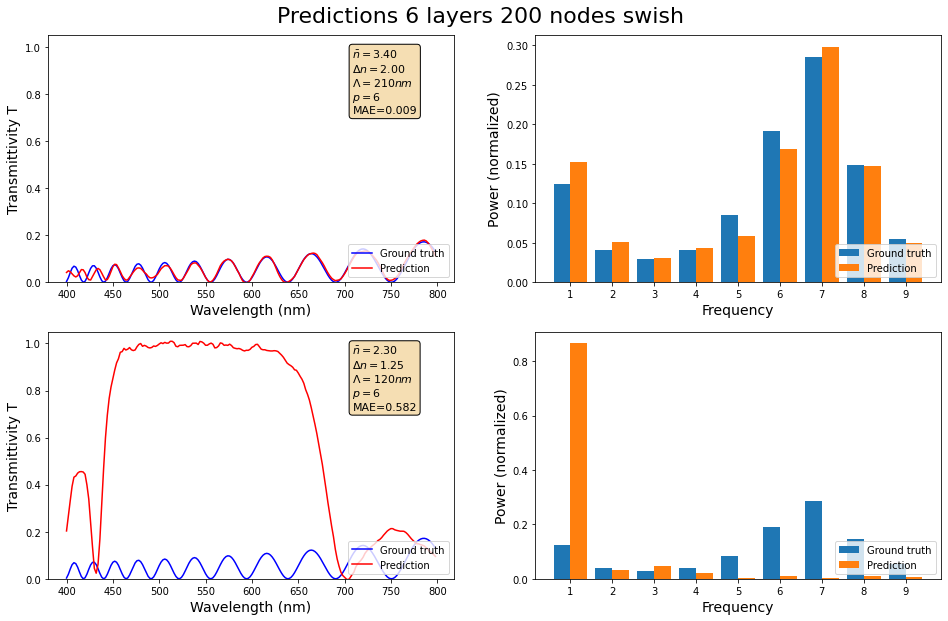

In [33]:
# Shows the a local and the global minimum for transmission 82 of the test set
# the transmissions and their fourier spectra are given 

def predict(vector_eval, y_eval, model, string="Predictions", swish_bool=False):
  pred = model.predict(vector_eval)
  vector_eval_denorm = unnormalize(vector_eval)

  plt.figure("Predictions", figsize = (16,10))
  plt.suptitle(string, fontsize = 22, y=0.92)
  for i in range(len(y_eval)):
    
    # Fourier
    ax = plt.subplot(np.ceil(len(y_eval)/2)*2,2,2*i + 2)
    cutoff = 10

    fourier = (np.abs(np.fft.fft(y_eval[i]))/200)**2
    power = sum(2*fourier[1:cutoff])
    fourier = 2*fourier[1:cutoff] / power

    fourier_pred = (np.abs(np.fft.fft(pred[i]))/200)**2
    power_pred = sum(2*fourier_pred[1:cutoff])
    fourier_pred = 2*fourier_pred[1:cutoff] / power_pred

    width=0.40
    ax.bar(np.arange(1, len(fourier) + 1) - width/2, fourier, width, label="Ground truth")
    ax.bar(np.arange(1, len(fourier) + 1) + width/2, fourier_pred, width, label="Prediction")
    plt.legend(loc = "lower right")
    plt.xticks(np.arange(1, 10))
    plt.xlabel("Frequency", fontsize=14)
    plt.ylabel("Power (normalized)", fontsize=14)

    textstr = '\n'.join((
      r'$Power=%.3f$' % (power),
      r'$Pred power=%.3f$' % (power_pred)
    ))
    props = dict(boxstyle='round', facecolor='wheat', alpha=1)
    
    # Signal
    ax = plt.subplot(np.ceil(len(y_eval)/2)*2,2,2*i+1)

    plt.plot(lamb, y_eval[i], 'b', label="Ground truth")
    plt.plot(lamb, pred[i], 'r', label="Prediction")
    plt.legend(loc = "lower right")
    plt.xlabel("Wavelength (nm)", fontsize=14)
    plt.ylabel("Transmittivity T", fontsize=14)
    plt.ylim(0, 1.05)

    err = tf.keras.losses.mean_absolute_error(y_eval[i], pred[i])
    textstr = '\n'.join((
      r'$\bar{n}=%.2f$' % (vector_eval_denorm[i][0]),
      r'$\Delta n=%.2f$' % (vector_eval_denorm[i][1]),
      r'$\Lambda=%.i nm$' % (vector_eval_denorm[i][2]),
      r'$p=%.i$' % (vector_eval_denorm[i][3]),
      r'MAE=%.3f' % (err)))
    props = dict(boxstyle='round', facecolor='wheat', alpha=1)
    ax.text(0.75, 0.95, textstr, transform=ax.transAxes, fontsize=11,
          verticalalignment='top', bbox = props)
    
np.random.seed(0)

vector_eval = np.array([vector_4_test[0], np.array([0.0, 0.0, -0.6, 0.0])])
y_eval = np.array([y_test[0], y_test[0]])

best_model = best_res['Saved as'].values[0]
Fulcon = tf.keras.models.load_model(path + best_model,
                                    custom_objects={'Activation' : tf.keras.layers.Activation(swish)})
predict(vector_eval, y_eval, 
        model = Fulcon, 
        string="Predictions 6 layers 200 nodes swish")

## Gradient descent

In [53]:
import matplotlib.gridspec as gridspec
from matplotlib.cbook import get_sample_data
import matplotlib 
matplotlib.use('Agg')
from IPython import display
import matplotlib.pylab as pylab
import pandas as pd
import time

# Functions:
#   - plot_param: to create the plot
#   - make_gif: to combine all saved plots in a gif

def plot_param(param_list, vector_true, y_true, step, big):
  
  fig = plt.figure(figsize=(15, 11))
  plt.suptitle(f'Inverse design step {step}', fontsize=22, y=0.94)
  gs = gridspec.GridSpec(2, 3)

  last_step = (step == (len(param_list['loss']) - 1))
  current_param = [param_list['n_av'][step],
                   param_list['dn'][step], 
                   param_list['big_lamb'][step],
                   param_list['p'][step],
                   param_list['loss'][step]]
  if step == 0:
    current_param[2] = param_list['loss'][1]
  loss_true = param_list['loss'][0]
  
  # Predictions to plot spectrum
  x_in = tf.expand_dims(tf.convert_to_tensor(current_param[0:4]), axis=0)
  y_pred = Fulcon(inputs=x_in)[0]
  
  # Show Fourier
  ax = plt.subplot(gs[0, 0])

  fourier_true = (np.abs(np.fft.fft(y_true))/200)**2
  DC_true = fourier_true[0]
  power_true = sum(2*fourier_true[1:10])
  fourier_true = 2*fourier_true[1:10] / power_true

  fourier_pred = (np.abs(np.fft.fft(y_pred))/200)**2
  DC_pred = fourier_pred[0]
  power_pred = sum(2*fourier_pred[1:10])
  fourier_pred = 2*fourier_pred[1:10] / power_pred

  width = 0.35
  ax.bar(np.arange(1, 10) - width/2, fourier_true, width, label='Ground truth')
  ax.bar(np.arange(1, 10) + width/2, fourier_pred, width, label='Prediction')
  plt.legend(loc = 'upper right', fontsize=14)
  plt.ylim([0, 1])
  plt.xlabel("Frequencies", fontsize=16)
  plt.ylabel("Power (normalized)", fontsize=16)

  fourier_loss = tf.keras.losses.mean_absolute_error(fourier_true, fourier_pred)
  textstr = '\n'.join((
      f'$MAE=%.3f$' % (fourier_loss),
    ))
  props = dict(boxstyle='round', facecolor='wheat', alpha=1)

  # Big makes the image suited for the thesis
  
  if not big:
    ax.text(0.60, 0.95, textstr, transform=ax.transAxes, fontsize=13,
            verticalalignment='top', bbox = props)

  # Plot f1 and f3
  plt.subplot(gs[0, 1])
  n_av_list = param_list['n_av']
  dn_list = param_list['dn']
  plt.plot([vector_true[0] for i in range(len(n_av_list) + 1)], 'C1--', label='Ground truth n_av')
  plt.plot([0] + n_av_list, 'C1', label='Prediction n_av')
  plt.plot([vector_true[1] for i in range(len(dn_list) + 1)], 'b--', label='Ground truth dn')
  plt.plot([0] + dn_list, 'b', label='Prediction dn')
  plt.plot(step, current_param[0], 'ro')
  plt.plot(step, current_param[1], 'ro')
  plt.xlabel('Iteration', fontsize=16)
  plt.ylabel('n, dn', fontsize=18, rotation=0)
  plt.ylim([-1.05, 1.05]) 
  plt.legend(fontsize=11, loc='upper right')
  plt.xticks(fontsize=14)
  plt.yticks(fontsize=11)

  # Plot big_lamb and p
  plt.subplot(gs[0, 2])
  big_lamb_list = param_list['big_lamb']
  p_list = param_list['p']
  plt.plot([vector_true[2] for i in range(len(big_lamb_list) + 1)], 'C1--', label='Ground truth big lambda')
  plt.plot([0] + big_lamb_list, 'C1', label='Prediction big lambda')
  plt.plot([vector_true[3] for i in range(len(p_list) + 1)], 'b--', label='Ground truth p')
  plt.plot([0] + p_list, 'b', label='Prediction p')
  plt.plot(step, current_param[2], 'ro')
  plt.plot(step, current_param[3], 'ro')
  plt.xlabel('Iteration', fontsize=16)
  plt.ylabel('lamb, p', fontsize=18, rotation=0)
  plt.ylim([-1.05, 1.05]) 
  plt.legend(fontsize=11, loc='upper right')
  plt.xticks(fontsize=14)
  plt.yticks(fontsize=11)

  # Plot spectrum
  ax = plt.subplot(gs[1, 0:2])
  
  """img_path = path + "bragg full/petitprincecut2.png"
  img = plt.imread(get_sample_data(img_path))
  ax.imshow(img, zorder=0, extent=[0, 840, 0, 420])
  plt.plot(2*(lamb - 400) + 10, y_true*400, 'b', label="Ground truth", zorder=1)
  plt.plot(2*(lamb - 400) + 10, y_pred*400, 'r', label='Prediction', zorder=1)
  plt.xticks(ticks=[20 + 100*i for i in range(9)], labels=[400 + 50*i for i in range(9)], fontsize=14)
  plt.yticks(ticks=[400*0.2*i for i in range(6)], labels=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=14)"""

  plt.plot(lamb, y_true, 'b', label='Ground truth')
  plt.plot(lamb, y_pred, 'r', label="Prediction")
  plt.legend(loc = "upper right", fontsize=14)
  plt.xlabel("Wavelength (nm)", fontsize=16)
  plt.ylabel("Reflectivity R", fontsize=16)
  plt.ylim(0, 1.05)

  err = tf.keras.losses.mean_absolute_error(y_true, y_pred)
  textstr = '\n'.join((
    r'$f_1=%.1f$' % (current_param[0]),
    r'$f_2=%.3f$' % (current_param[1]),
    r'MAE=%.3f' % (err)))
  props = dict(boxstyle='round', facecolor='wheat', alpha=1)
  
  if not big:
    ax.text(0.80, 0.95, textstr, transform=ax.transAxes, fontsize=13,
            verticalalignment='top', bbox = props)
  
  # Plot loss
  ax = plt.subplot(gs[1, 2])
  loss_list = param_list['loss']
  plt.plot([loss_true for i in range(len(loss_list))], '--', label='Ground truth')
  plt.plot([loss_list[1]] + loss_list[1:], 'C1', label='Prediction')
  plt.plot(step, current_param[-1], 'ro')
  plt.xlabel('Iteration', fontsize=16)
  plt.ylabel('Loss (mse)', fontsize=16)
  #plt.xticks(range(0, len(loss_list) + 1, 10))
  #plt.ylim([loss_true/10, max(loss_list) * 1.1]) 
  plt.yscale('log')
  plt.legend(fontsize=14)
  plt.xticks(fontsize=14)
  plt.yticks(fontsize=14)

  plt.subplots_adjust(wspace=0.35)
  plt.savefig(path + path_exp + f"temp/step {step}.png")
  if last_step:
    plt.show()
  else:
    plt.close(fig)

def make_gif(i, path_exp, mult_param, skip, multiple_inits, y_true, vector_true, big):

  param_len = len(mult_param[0]['loss']) # param_len = epochs + 1

  # Make a plot for every param in param_list, including initial parameters
  for step in range(param_len): 
    if step % skip == 0:
      print(f"Plotting step {step}...")
      if multiple_inits:
        plot_mult_param(mult_param, vector_true, y_true, step)
      else:
        param_list = mult_param[0]
        plot_param(param_list, vector_true, y_true, step, big)

  # Turn plots into gif
  import imageio
  anim_file = path + path_exp + f"gifs/Inverse design - transmission {i}.gif"
  
  with imageio.get_writer(anim_file, mode='I') as writer:
    for i in range(param_len):
      if i % skip == 0:
        filename = path + path_exp + "temp/" + f"step {i}.png"
        image = imageio.imread(filename)
        writer.append_data(image)

In [37]:
# Functions:
#   - mse_loss: the loss function that we are minimizing with gradient descent
#   - compute_params: the actual gradient descent, gives the evolution of 
#                     F, d and loss during training as output in param_list

@tf.function
def mse_loss(x, y_true):
  x = tf.expand_dims(x, axis=0)
  y_pred = Fulcon(inputs=x)[0]

  signal_loss = tf.keras.losses.mean_squared_error(y_true, y_pred)

  loss = signal_loss 
  return loss

# CHANGE OPTIMIZATION METHOD HERE 
def compute_params(init_list, y_true, epochs, verbose=True, re_initialize=True):
  param_list = init_list

  optimizer = tf.keras.optimizers.Adam(lr=0.005) #0.001

  # Initialize tensors
  n_av_step = tf.Variable(init_list['n_av'][0])
  dn_step = tf.Variable(init_list['dn'][0])
  big_lamb_step = tf.Variable(init_list['big_lamb'][0])
  p_step = tf.Variable(init_list['p'][0])

  loss = tf.constant(0.0)
  new_param = np.array([init_list['n_av'][0],
                        init_list['dn'][0],
                        init_list['big_lamb'][0],
                        init_list['p'][0]])
  if verbose:
    print(f"Initial n_av guess: {n_av_step.numpy():.05f}, for f2 = 0.0, f3 = 0.0, f4 = 0.0")
    print(f"Initial dn guess: {dn_step.numpy():.05f}, for f1 = 0.0, f3 = 0.0, f4 = 0.0")
    print(f"Initial big_lamb guess: {big_lamb_step.numpy():.05f}, for f1 = 0.0, f2 = 0.0, f4 = 0.0")
    print(f"Initial p guess: {p_step.numpy():.05f}, for f1 = 0.0, f2 = 0.0, f3 = 0.0")

  # Start gradient descent iterations
  for i in range(epochs):
    old_param = new_param

    # re-initialize every 100 epochs if re-initialize = true
    n_av_step_old = n_av_step.numpy()
    dn_step_old = dn_step.numpy()
    big_lamb_step_old = big_lamb_step.numpy()
    p_step_old = p_step.numpy()

    if i % 600 == 0 and i != 0 and re_initialize and loss > 5*10**(-3):
      n_av_step.assign(f_guess([n_av_step_old, dn_step_old, big_lamb_step_old, p_step_old], y_true, j=1)[0])
      p_step.assign(f_guess([n_av_step_old, dn_step_old, big_lamb_step_old, p_step_old], y_true, j=4)[0])
     
      if verbose:
        print(f"Epoch {i} n_av guess: {n_av_step.numpy():.05f}")
        print(f"Epoch {i} p guess: {p_step.numpy():.05f}") 

    elif i % 300 == 0 and i != 0 and re_initialize and loss > 5*10**(-3):
      big_lamb_step.assign(f_guess([n_av_step_old, dn_step_old, big_lamb_step_old, p_step_old], y_true, j=2)[0])
      dn_step.assign(f_guess([n_av_step_old, dn_step_old, big_lamb_step_old, p_step_old], y_true, j=3)[0])

      if verbose:
        print(f"Epoch {i} big lamb guess: {big_lamb_step.numpy():.05f}")
        print(f"Epoch {i} dn guess: {dn_step.numpy():.05f}")

    # Calculate gradients
    with tf.GradientTape() as tape:
      loss = mse_loss(tf.convert_to_tensor([n_av_step, dn_step, big_lamb_step, p_step]), 
                      tf.convert_to_tensor(y_true))
      grad = tape.gradient(loss, [n_av_step, dn_step, big_lamb_step, p_step])

    optimizer.apply_gradients(zip(tf.convert_to_tensor(grad), [n_av_step, dn_step, big_lamb_step, p_step]))    
    new_param = [n_av_step.numpy(), dn_step.numpy(), big_lamb_step.numpy(), p_step.numpy()]
    
    param_list['n_av'].append(new_param[0])
    param_list['dn'].append(new_param[1])
    param_list['big_lamb'].append(new_param[2])
    param_list['p'].append(new_param[3])
    param_list['loss'].append(loss.numpy())

  return param_list

Inverse design of transmission 6921 (test set)
True: [ 0.41667 -0.44    -0.66667  0.25   ]
Initial n_av guess: 0.00000, for f2 = 0.0, f3 = 0.0, f4 = 0.0
Initial dn guess: -0.55556, for f1 = 0.0, f3 = 0.0, f4 = 0.0
Initial big_lamb guess: 0.00000, for f1 = 0.0, f2 = 0.0, f4 = 0.0
Initial p guess: 0.00000, for f1 = 0.0, f2 = 0.0, f3 = 0.0
Epoch 300 big lamb guess: 0.00000
Epoch 300 dn guess: 0.00000
True parameters: [ 0.41667 -0.44    -0.66667  0.25   ]
Final guess: [-0.57594454, -0.6795547, -0.20853683, 0.24388921]
MAE spectrum true: 0.00700, MAE spectrum guess: 0.00705
Plotting step 0...
Plotting step 200...
Plotting step 400...
Plotting step 600...
Plotting step 800...
Plotting step 1000...
Plotting step 1200...
Plotting step 1400...
Plotting step 1600...
Plotting step 1800...
Plotting step 2000...
I have been running for 0 mins 25 seconds


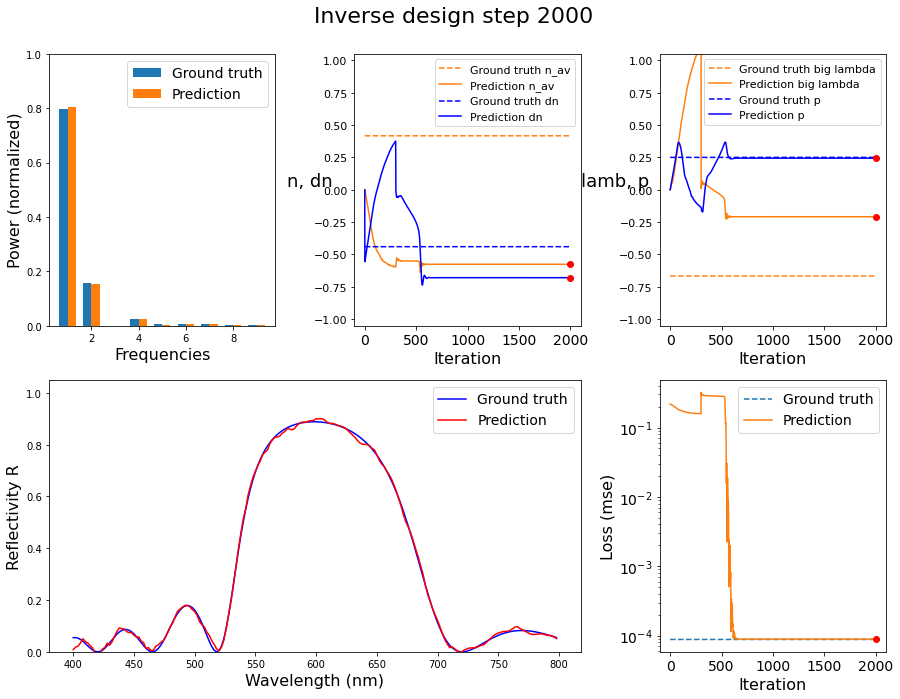

In [57]:
import os.path

# Functions:
#   - d_guess: finds the optimal d for a given value of F, 
#              minimizing the signal_loss, fourier_loss of a combination
#   - init_csv_design: initializes pd DataFrame to save results of inverse design
#   - add_row_to_csv: adds a row to the pd DataFrame each time we perform an inverse design
#   - inverse_design: performs inverse design on transmission i from the test set
#                     if gif=True, it makes a gif of the training process
#                     otherwise it saves the training into a pd DataFrame

def f_guess(f_other_full, y_true, j, treshold=0.15, verbose=False):
  best_loss = 20
  max_loss = 0.0
  best_f = 0.0
  # Big lambda constraint
  if j == 3:
    n_unnorm = (f_other_full[0] * 1.2) + 2.3
    big_lamb_min = ((200/n_unnorm) - 225) / 175
    big_lamb_max = ((400/n_unnorm) - 225) / 175
    f_tries = np.linspace(big_lamb_min, big_lamb_max, 100)
  else:
    f_tries = np.linspace(-1, 1, 100)

  # Calculate Fourier space of y_true
  complex_true = tf.signal.fft(tf.cast(y_true, dtype=tf.complex64))/200
  fourier_true = (tf.abs(complex_true))**2
  power_true = tf.reduce_sum(2*fourier_true[1:10])
  fourier_true = 2*fourier_true[1:10] / power_true

  # Loop over possible values of delta (d)
  for f in f_tries:
    f_other_full[j - 1] = f
    x = tf.expand_dims(np.array(f_other_full), axis=0)
    x = tf.convert_to_tensor(x)
    y_pred = Fulcon(inputs=x)[0]

    # Calculate Fourier space of y_true
    complex_pred = tf.signal.fft(tf.cast(y_pred, dtype=tf.complex64))/200
    fourier_pred = (tf.abs(complex_pred))**2
    power_pred = tf.reduce_sum(2*fourier_pred[1:10])
    fourier_pred = 2*fourier_pred[1:10] / power_pred
  
    # Calculate loss for this value of f
    fourier_loss = tf.keras.losses.mean_squared_error(fourier_true, fourier_pred)
    signal_loss = tf.keras.losses.mean_squared_error(y_pred, y_true).numpy()

    loss = fourier_loss + signal_loss

    # Change lowest loss so far
    if loss < best_loss:
      best_loss = loss
      best_f = f
    elif loss > max_loss:
      max_loss = loss

  if verbose:
    print(f"j = {j}, best loss = {best_loss} for f = {best_f}")

  if best_loss > treshold or best_loss * 1.5 > max_loss:
    best_loss = 20
    best_f = 0.0

  return best_f, best_loss

def init_csv_design(savename):
  df = pd.DataFrame(columns=["Number", "n_av true", "n_av guess", "dn true", "dn guess",
                             "big_lamb true", "big_lamb guess", "p true", "p guess", 
                             "MAE ground truth", "MAE spectrum"])
  df.to_csv(path + savename)

def add_row_to_csv(row, savename):
  df = pd.read_csv(path + savename, index_col=0)
  df = df.append(row, ignore_index=True)
  df.to_csv(path + savename)

def inverse_design(i, gif, verbose, big):
  vector_true = vector_4_test[i]
  if verbose: 
    print(f"True: {vector_true}")
  y_true = y_test[i]
  """elephant = np.array([0.55, 0.551, 0.554, 0.557, 0.561, 0.565, 0.568, 0.569, 0.570, 0.571, 0.572, 0.573] + 
                    [0.573, 0.573, 0.573, 0.572, 0.572, 0.572, 0.572, 0.572, 0.572, 0.571, 0.571, 0.571, 0.572, 0.573, 0.575] + 
                    [0.577, 0.581, 0.585, 0.589, 0.594] + [0.60, 0.607, 0.612, 0.62, 0.63, 0.67, 0.72, 0.77, 0.81, 0.84, 0.87, 0.89, 0.902] + 
                    [0.905, 0.913, 0.921, 0.929, 0.935, 0.940, 0.945, 0.949, 0.953, 0.956, 0.959, 0.961, 0.963, 0.965, 0.966] +
                    [0.966, 0.966, 0.966, 0.966, 0.966, 0.966, 0.966, 0.966, 0.966, 0.966] +
                    [0.966, 0.965, 0.963, 0.961, 0.959, 0.957, 0.955, 0.953, 0.951, 0.950] +
                    [0.950, 0.947, 0.943, 0.940, 0.936, 0.931, 0.925, 0.920, 0.915, 0.910] +
                    [0.905, 0.900, 0.895, 0.890, 0.886, 0.883, 0.880, 0.876, 0.873, 0.87] +
                    [0.868 for i in range(15)] + [0.867, 0.866, 0.864, 0.862, 0.860, 0.858, 0.856, 0.854, 0.852, 0.847] +
                    [0.846, 0.83, 0.81, 0.79, 0.77, 0.75, 0.73, 0.71, 0.69, 0.67, 0.65, 0.63, 0.62] +
                    [0.61, 0.60, 0.594, 0.592, 0.589, 0.587, 0.584, 0.580, 0.578, 0.576, 0.574, 0.572, 0.570] +
                    [0.570 for i in range(35)] +
                    [0.570, 0.572, 0.575, 0.579, 0.583] + 
                    [0.587, 0.590, 0.594, 0.597, 0.601, 0.603, 0.604, 0.602, 0.60])  # ELEPHANT
  y_true = (elephant-0.55)*2"""
  y_pred_true = Fulcon(np.array([vector_true]))[0]
  signal_loss_true = tf.keras.losses.mean_squared_error(y_true, y_pred_true)

  # Initialize F and d0
  #f1_init_old, best_1_old = f_guess([0.0, 0.0, 0.0, 0.0], y_true, j=1, treshold = 0.1, verbose=verbose)
  #f2_init_old, best_2_old = f_guess([0.0, 0.0, 0.0, 0.0], y_true, j=2, treshold = 0.1, verbose=verbose)

  n_av_init, best_1 = f_guess([0.0, 0.0, -0.5, 0.0], y_true, j=1, treshold = 0.15)
  dn_init, best_2 = f_guess([0.0, 0.0, -0.5, 0.0], y_true, j=2, treshold = min(best_1, 0.15))
  # Step only in best of f1 or f2
  if best_2 < 0.1:
    f1_init = 0.0

  #f3_init_old, best_3 = f_guess([0.0, 0.0, 0.0, 0.0], y_true, j=3, treshold=0.1, verbose=verbose)
  #f4_init_old, best_4 = f_guess([0.0, 0.0, 0.0, 0.0], y_true, j=4, treshold=0.1, verbose=verbose)

  big_lamb_init, best_3 = f_guess([0.0, 0.0, -0.5, 0.0], y_true, j=3, treshold=0.15)
  p_init, best_4 = f_guess([0.0, 0.0, -0.5, 0.0], y_true, j=4, treshold=min(best_3, 0.15))
  # Step only in best of f3 or f4
  """if best_4 < 0.1:
    f3_init = 0.0"""

  init_param = {'n_av' : [float(n_av_init)], 'dn' : [float(dn_init)], 
                'big_lamb' : [float(0.0)], 'p' : [float(0.0)],
                'loss' : [signal_loss_true.numpy()]} 

  # Start gradient descent
  param_list = compute_params(init_param, y_true, epochs=2000, 
                              verbose=verbose, re_initialize=True)

  # Calculate MAE between predicted and true transmission signal_mae_guess
  # compare this to signal_mae_true, which is the MAE due to the inaccuracy of the neural network
  vector_guess = [param_list['n_av'][-1], param_list['dn'][-1], param_list['big_lamb'][-1], param_list['p'][-1]]
  mae_guess = tf.keras.losses.mean_absolute_error(vector_true, vector_guess)
  y_pred_guess = Fulcon(np.array([vector_guess]))[0]

  signal_mae_guess = tf.keras.losses.mean_absolute_error(y_true, y_pred_guess)
  signal_mae_true = tf.keras.losses.mean_absolute_error(y_true, y_pred_true)

  if verbose:
    np.set_printoptions(precision=5)
    print(f"True parameters: {vector_true}")
    print(f"Final guess: {vector_guess}")
    print(f"MAE spectrum true: {signal_mae_true:.05f}, MAE spectrum guess: {signal_mae_guess:.05f}")

  if gif:
    make_gif(i=i, path_exp=path_exp, mult_param=[param_list], skip=200, multiple_inits=False, 
             y_true=y_true, vector_true=vector_true, big=big)
  else:
    row = pd.Series(index=["Number", "n_av true", "n_av guess", "dn true", "dn guess",
                             "big_lamb true", "big_lamb guess", "p true", "p guess", 
                             "MAE ground truth", "MAE spectrum"],
                    data= [i, vector_true[0], vector_guess[0], vector_true[1], vector_guess[1],
                           vector_true[2], vector_guess[2], vector_true[3], vector_guess[3],
                           signal_mae_true.numpy(), signal_mae_guess.numpy()])
    add_row_to_csv(row, savename)

path_exp = "Bragg reflector/"

savename = path_exp + "Inverse design.csv"

if not os.path.isfile(path + savename):
  print("Created new csv file!")
  init_csv_design(savename)

start = time.time()
for i in [6921]:
  print(f"Inverse design of transmission {i} (test set)")
  inverse_design(i, gif=True, verbose=True, big=True)
  if i % 1 == 0:
    diff = time.time() - start  
    print(f"I have been running for {int(np.floor(diff / 60))} mins {int(diff % 60)} seconds")

## Paper figures

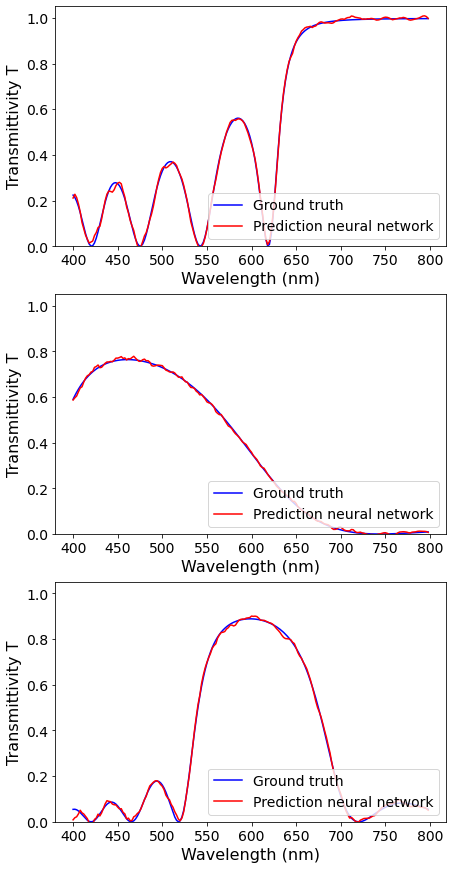

In [58]:
def inverse_design_figure(i_list, verbose):
  plt.figure(figsize=(7, 15))

  bragg_result_list = list()
  for j, i in enumerate(i_list): 
    vector_true = vector_4_test[i]
    y_true = y_test[i]
    y_pred_true = Fulcon(np.array([vector_true]))[0]
    signal_loss_true = tf.keras.losses.mean_squared_error(y_true, y_pred_true)

    n_av_init, best_1 = f_guess([0.0, 0.0, -0.5, 0.0], y_true, j=1, treshold = 0.15, verbose=verbose)
    dn_init, best_2 = f_guess([0.0, 0.0, -0.5, 0.0], y_true, j=2, treshold = min(best_1, 0.15), verbose=verbose)
    # Step only in best of f1 or f2
    if best_2 < 0.1:
      f1_init = 0.0

    init_param = {'n_av' : [float(n_av_init)], 'dn' : [float(dn_init)], 
                  'big_lamb' : [float(0.0)], 'p' : [float(0.0)],
                  'loss' : [signal_loss_true.numpy()]} 

    # Start gradient descent
    param_list = compute_params(init_param, y_true, epochs=2000, 
                                verbose=verbose, re_initialize=True)

    # Calculate MAE between predicted and true transmission signal_mae_guess
    # compare this to signal_mae_true, which is the MAE due to the inaccuracy of the neural network
    vector_guess = [param_list['n_av'][-1], param_list['dn'][-1], param_list['big_lamb'][-1], param_list['p'][-1]]
    y_pred_guess = Fulcon(np.array([vector_guess]))[0]

    signal_mae_guess = tf.keras.losses.mean_absolute_error(y_true, y_pred_guess)
    signal_mae_true = tf.keras.losses.mean_absolute_error(y_true, y_pred_true)

    if verbose:
      np.set_printoptions(precision=5)
      print(f"True parameters: {vector_true}")
      print(f"Final guess: {vector_guess}")
      print(f"MAE true: {signal_mae_true:.05f}, MAE guess: {signal_mae_guess:.05f} ")

    # Plot spectrum
    plt.subplot(3, 1, j+1)
    plt.plot(lamb, y_true, 'b', label='Ground truth')
    plt.plot(lamb, y_pred_guess, 'r', label='Prediction neural network')
    plt.legend(loc = "lower right", fontsize=14)
    plt.xlabel("Wavelength (nm)", fontsize=16)
    plt.ylabel("Transmittivity T", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.ylim(0, 1.05)

    bragg_result_list.append(y_true)
    bragg_result_list.append(y_pred_guess)
  bragg_result = np.array(bragg_result_list)
  np.save(path + "bragg_result.npy", bragg_result)

  plt.show()

inverse_design_figure([1, 3468, 6921], verbose=False)

Elephant shape: (2, 200)


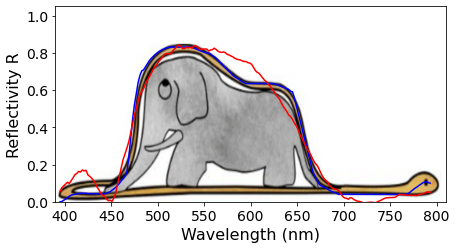

In [44]:
def inverse_design_elephant(verbose):
  plt.figure(figsize=(7, 15))

  elephant = np.array([0.55, 0.551, 0.554, 0.557, 0.561, 0.565, 0.568, 0.569, 0.570, 0.571, 0.572, 0.573] + 
                    [0.573, 0.573, 0.573, 0.572, 0.572, 0.572, 0.572, 0.572, 0.572, 0.571, 0.571, 0.571, 0.572, 0.573, 0.575] + 
                    [0.577, 0.581, 0.585, 0.589, 0.594] + [0.60, 0.607, 0.612, 0.62, 0.63, 0.67, 0.72, 0.77, 0.81, 0.84, 0.87, 0.89, 0.902] + 
                    [0.905, 0.913, 0.921, 0.929, 0.935, 0.940, 0.945, 0.949, 0.953, 0.956, 0.959, 0.961, 0.963, 0.965, 0.966] +
                    [0.966, 0.966, 0.966, 0.966, 0.966, 0.966, 0.966, 0.966, 0.966, 0.966] +
                    [0.966, 0.965, 0.963, 0.961, 0.959, 0.957, 0.955, 0.953, 0.951, 0.950] +
                    [0.950, 0.947, 0.943, 0.940, 0.936, 0.931, 0.925, 0.920, 0.915, 0.910] +
                    [0.905, 0.900, 0.895, 0.890, 0.886, 0.883, 0.880, 0.876, 0.873, 0.87] +
                    [0.868 for i in range(15)] + [0.867, 0.866, 0.864, 0.862, 0.860, 0.858, 0.856, 0.854, 0.852, 0.847] +
                    [0.846, 0.83, 0.81, 0.79, 0.77, 0.75, 0.73, 0.71, 0.69, 0.67, 0.65, 0.63, 0.62] +
                    [0.61, 0.60, 0.594, 0.592, 0.589, 0.587, 0.584, 0.580, 0.578, 0.576, 0.574, 0.572, 0.570] +
                    [0.570 for i in range(35)] +
                    [0.570, 0.572, 0.575, 0.579, 0.583] + 
                    [0.587, 0.590, 0.594, 0.597, 0.601, 0.603, 0.604, 0.602, 0.60])  # ELEPHANT"""
  y_true = (elephant-0.55)*2

  n_av_init, best_1 = f_guess([0.0, 0.0, -0.5, 0.0], y_true, j=1, treshold = 0.15, verbose=verbose)
  dn_init, best_2 = f_guess([0.0, 0.0, -0.5, 0.0], y_true, j=2, treshold = min(best_1, 0.15), verbose=verbose)
  # Step only in best of f1 or f2
  if best_2 < 0.1:
    f1_init = 0.0

  init_param = {'n_av' : [float(n_av_init)], 'dn' : [float(dn_init)], 
                'big_lamb' : [float(0.0)], 'p' : [float(0.0)],
                'loss' : [20]} 

  # Start gradient descent
  param_list = compute_params(init_param, y_true, epochs=2000, 
                                verbose=verbose, re_initialize=True)

  # Calculate MAE between predicted and true transmission signal_mae_guess
  # compare this to signal_mae_true, which is the MAE due to the inaccuracy of the neural network
  vector_guess = [param_list['n_av'][-1], param_list['dn'][-1], param_list['big_lamb'][-1], param_list['p'][-1]]
  y_pred_guess = Fulcon(np.array([vector_guess]))[0]

  signal_mae_guess = tf.keras.losses.mean_absolute_error(y_true, y_pred_guess)

  if verbose:
    np.set_printoptions(precision=5)
    print(f"True parameters: {vector_true}")
    print(f"Final guess: {vector_guess}")
    print(f"MAE guess: {signal_mae_guess:.05f} ")

  # Plot spectrum
  img_path = path + "Bragg reflector/petitprincecut2.png"
  img = plt.imread(get_sample_data(img_path))

  ax = plt.subplot(1, 1, 1)
  ax.imshow(img, zorder=0, extent=[0, 840, 0, 420])
  plt.plot(2*(lamb - 400) + 10, y_true*400, 'b', label="Ground truth", zorder=1)
  plt.plot(2*(lamb - 400) + 10, y_pred_guess*400, 'r', label='Prediction', zorder=1)

  plt.xlabel("Wavelength (nm)", fontsize=16)
  plt.ylabel("Reflectivity R", fontsize=16)
  plt.xticks(ticks=[20 + 100*i for i in range(9)], labels=[400 + 50*i for i in range(9)], fontsize=14)
  plt.yticks(ticks=[400*0.2*i for i in range(6)], labels=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=14)
  plt.ylim(0, 420)

  bragg_elephant = np.array([y_true, y_pred_guess])
  np.save(path + "bragg_elephant.npy", bragg_elephant)
  print(f"Elephant shape: {bragg_elephant.shape}")

  plt.show()

inverse_design_elephant(verbose=False)

<Figure size 432x864 with 0 Axes>

Text(0.5, 0, 'Wavelength (nm)')

Text(0, 0.5, 'Transmittivity T')

(array([350., 400., 450., 500., 550., 600., 650., 700., 750., 800., 850.]),
 <a list of 11 Text major ticklabel objects>)

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 <a list of 8 Text major ticklabel objects>)

(0.0, 1.05)

Text(0.5, 0, 'Wavelength (nm)')

Text(0, 0.5, 'Transmittivity T')

(array([350., 400., 450., 500., 550., 600., 650., 700., 750., 800., 850.]),
 <a list of 11 Text major ticklabel objects>)

(array([-0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9]),
 <a list of 11 Text major ticklabel objects>)

(0.0, 1.05)

Text(0.5, 0, 'Wavelength (nm)')

Text(0, 0.5, 'Transmittivity T')

(array([350., 400., 450., 500., 550., 600., 650., 700., 750., 800., 850.]),
 <a list of 11 Text major ticklabel objects>)

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 7 Text major ticklabel objects>)

(0.0, 1.05)

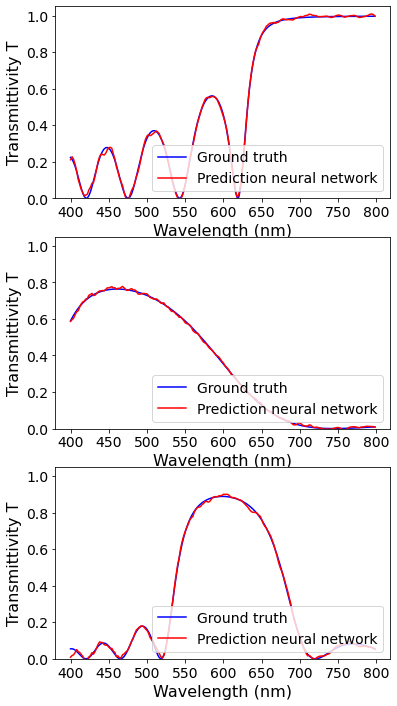

In [45]:
# Plot bragg result

new_bragg = np.load(path + "bragg_result.npy")

plt.figure(figsize=(6, 12))
for i in range(3):
  plt.subplot(3, 1, i+1)
  plt.plot(lamb, new_bragg[2*i], 'b', label='Ground truth')
  plt.plot(lamb, new_bragg[2*i + 1], 'r', label='Prediction neural network')
  plt.legend(loc = "lower right", fontsize=14)
  plt.xlabel("Wavelength (nm)", fontsize=16)
  plt.ylabel("Transmittivity T", fontsize=16)
  plt.xticks(fontsize=14)
  plt.yticks(fontsize=14)
  plt.ylim(0, 1.05)
plt.show()

<Figure size 504x432 with 0 Axes>

Text(0.5, 0, 'Wavelength (nm)')

Text(0, 0.5, 'Reflectivity R')

([<matplotlib.axis.XTick at 0x7f5ca7784cf8>,
 [Text(0, 0, '400'),
  Text(0, 0, '450'),
  Text(0, 0, '500'),
  Text(0, 0, '550'),
  Text(0, 0, '600'),
  Text(0, 0, '650'),
  Text(0, 0, '700'),
  Text(0, 0, '750'),
  Text(0, 0, '800')])

([<matplotlib.axis.YTick at 0x7f5cb01c5550>,
 [Text(0, 0, '0.0'),
  Text(0, 0, '0.2'),
  Text(0, 0, '0.4'),
  Text(0, 0, '0.6'),
  Text(0, 0, '0.8'),
  Text(0, 0, '1.0')])

(0.0, 420.0)

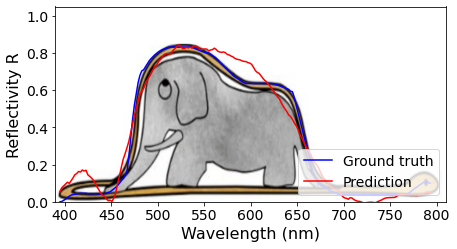

In [47]:
# Plot elephant

new_elephant = np.load(path + "bragg_elephant.npy")

plt.figure(figsize=(7, 6))
img_path = path + "Bragg reflector/petitprincecut2.png"
img = plt.imread(get_sample_data(img_path))

ax = plt.subplot(1, 1, 1)
ax.imshow(img, zorder=0, extent=[0, 840, 0, 420])
plt.plot(2*(lamb - 400) + 10, new_elephant[0]*400, 'b', label="Ground truth", zorder=1)
plt.plot(2*(lamb - 400) + 10, new_elephant[1]*400, 'r', label='Prediction', zorder=1)

plt.xlabel("Wavelength (nm)", fontsize=16)
plt.ylabel("Reflectivity R", fontsize=16)
plt.xticks(ticks=[20 + 100*i for i in range(9)], labels=[400 + 50*i for i in range(9)], fontsize=14)
plt.yticks(ticks=[400*0.2*i for i in range(6)], labels=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=14)
plt.ylim(0, 420)
plt.legend(loc = "lower right", fontsize=14)

plt.show()

## Simulated annealing

Implementation as in:

https://perso.crans.org/besson/publis/notebooks/Simulated_annealing_in_Python.html

In [59]:
# basic annealing vindt het globaal minimimum niet met maxsteps 15000 of minder
# random_neighbour verbeteren? 

def annealing(cost_function, random_neighbour, acceptance_probability, 
              temperature, maxsteps=1000, debug=True):
    """ Optimize the black-box function 'cost_function' with the simulated annealing algorithm."""
    state = [0.0, 0.0, 0.0, 0.0]
    cost = cost_function(state)
    states, costs = [state], [cost]

    for step in range(maxsteps):
        fraction = step / float(maxsteps)
        T = temperature(fraction)
        new_state = random_neighbour(state, 1 - fraction)
        new_cost = cost_function(new_state)
        if debug and (step + 1) % 100 == 0: 
          np.set_printoptions(precision=3)
          print(f"Step {step+1}/{maxsteps} : T = {T:.02f}, state = {state}, cost = {cost:.05f}")
        if acceptance_probability(cost, new_cost, T) > np.random.random():
            state, cost = new_state, new_cost
            states.append(state)
            costs.append(cost)
    return state, cost_function(state), states, costs

In [60]:
def clip(x):
    """ Force x to be in the interval."""
    a, b = -1., 1.
    return np.array([max(min(x[i], b), a) for i in range(4)])

def random_neighbour(x, fraction=1):
    """ Stochastically roposes new states"""
    interval_length = 2
    amplitude = (interval_length) * fraction / 10
    delta = np.array([amplitude * (np.random.random_sample() - 1./2.) for i in range(4)])
    return clip(x + delta)

def acceptance_probability(cost, new_cost, temperature):
    """ Probability for the new state to be excepted"""
    if new_cost < cost:
        return 1
    else:
        p = np.exp(- (new_cost - cost) / temperature)
        return p

def temperature(fraction):
    """ Example of temperature dicreasing as the process goes on."""
    return max(0.01, min(1, 1 - fraction))

In [62]:
def cost_function(x):
  "The MSE loss on the transmissions"
  x = tf.expand_dims(x, axis=0)
  y_pred = Fulcon(inputs=x)[0]

  signal_loss = tf.keras.losses.mean_squared_error(y_true, y_pred)

  loss = signal_loss 
  return loss.numpy()

def cost_function_analytic(x):
  "The MSE loss on the transmissions"
  lamb = np.arange(400, 800, 2).astype('float32')
  vector_4 = unnormalize(np.array(x))

  n_av, dn, big_lamb, p = vector_4
  l = p*big_lamb
  kappa = (2*dn)/lamb
  delta = (2*np.pi*n_av/lamb) - (np.pi/big_lamb)
  gamma = np.sqrt(kappa**2 - delta**2 + 0j)

  numerator = (kappa**2) * np.sinh(gamma*l)**2
  denominator = (gamma**2) * np.cosh(gamma*l)**2 + (delta**2) * np.sinh(gamma*l)**2
  
  y_pred = np.real(numerator/denominator)

  signal_loss = tf.keras.losses.mean_squared_error(y_true, y_pred)

  loss = signal_loss 
  return loss.numpy()

vector_true = vector_4_test[0]
y_true = y_test[0]

state, cost, states, costs = annealing(cost_function=cost_function, random_neighbour=random_neighbour, 
                                       acceptance_probability=acceptance_probability, 
                                       temperature=temperature, maxsteps=1000, debug=True);

print(f"\nSimulated annealing: {state}")
print(f"True parameters: {vector_true}")
print(f"\nMAE = {np.sqrt(cost)}")

Step 100/1000 : T = 0.90, state = [ 0.96  -0.06  -0.614 -0.97 ], cost = 0.04777
Step 200/1000 : T = 0.80, state = [ 0.522 -0.387  0.006 -0.5  ], cost = 0.00418
Step 300/1000 : T = 0.70, state = [ 0.049 -0.981  0.358 -0.231], cost = 0.00554
Step 400/1000 : T = 0.60, state = [ 0.753 -0.99   0.348 -0.636], cost = 0.00566
Step 500/1000 : T = 0.50, state = [ 0.967 -0.752  0.161 -0.531], cost = 0.00551
Step 600/1000 : T = 0.40, state = [ 0.948 -0.885 -0.069 -0.973], cost = 0.00644
Step 700/1000 : T = 0.30, state = [ 0.74  -0.715 -0.296 -0.903], cost = 0.00485
Step 800/1000 : T = 0.20, state = [ 0.708 -0.908 -0.341 -0.608], cost = 0.00577
Step 900/1000 : T = 0.10, state = [ 0.653 -0.959 -0.282 -0.637], cost = 0.00584
Step 1000/1000 : T = 0.01, state = [ 0.664 -0.977 -0.282 -0.6  ], cost = 0.00585

Simulated annealing: [ 0.664 -0.977 -0.281 -0.6  ]
True parameters: [ 0.917  0.6   -0.083  0.   ]

MAE = 0.0764767974615097


In [ ]:
# Dual annealing works very well but rather slow

from scipy.optimize import dual_annealing
import time

def callback(x, f, context):
  print(f"State: {x}, Cost: {f}")

vector_true = vector_4_test[6921]
y_true = y_test[6921]

start = time.time()
ret = dual_annealing(cost_function, bounds=[(-1., 1.), (-1., 1.), (-1., 1.), (-1., 1.)], 
                     seed=0, maxiter=10000, callback=callback)
diff = time.time() - start  

print(f"Simulated annealing: {ret.x}")
print(f"True parameters: {vector_true}")
print(f"\nMAE = {np.sqrt(ret.fun)}")
print(f"I have been running for {int(np.floor(diff / 60))} mins {int(diff % 60)} seconds")

State: [ 0.09763  0.43038  0.20553 -0.72927], Cost: 0.17213203012943268
State: [-0.10308 -0.2749  -0.49975  0.56545], Cost: 0.09222488105297089
State: [-0.10308 -0.2749  -0.49975 -0.43438], Cost: 0.080497607588768
State: [-0.10308 -0.2749  -0.49975 -0.76066], Cost: 0.06830767542123795
State: [-0.10308 -0.2749  -0.49914 -0.76066], Cost: 0.06817077845335007
State: [-0.10308 -0.33124 -0.49914 -0.76066], Cost: 0.0563785657286644
State: [-4.77477e-04 -3.31242e-01 -4.99139e-01 -7.60663e-01], Cost: 0.05059947073459625
State: [-0.0543  -0.63516 -0.5188   0.79279], Cost: 0.018969494849443436
State: [-0.0543  -0.63516 -0.5188   0.18266], Cost: 0.012589775025844574
State: [-0.04985 -0.63516 -0.5188   0.16931], Cost: 0.012037176638841629
State: [-0.04985 -0.63516 -0.5188   0.25236], Cost: 0.01093253493309021
State: [-0.04683 -0.63516 -0.5188   0.2463 ], Cost: 0.010600452311336994
State: [-0.04683 -0.53742 -0.5188   0.2463 ], Cost: 0.0020107722375541925
State: [-0.03302 -0.53742 -0.5188   0.2463 ],